# Libraries

In [1]:
import sys
sys.path.append("./")
from utils import train_test_split

from tqdm.auto import tqdm 
tqdm.pandas()
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# Preprocessing

In [2]:
DATA = "data/"

data = pd.read_csv(DATA + "fact_train_test.csv", sep=";")
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,"71,0",1
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,"210,0",3
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,"67,0",1
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,"67,0",1
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,"66,0",1
...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,"69,0",1
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,"70,0",1
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,"70,0",1
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,"207,0",3


In [3]:
data["period"] = pd.to_datetime(data["period"])
data["real_weight"] = data["real_weight"].apply(lambda x: float(x.replace(",", ".")))
data = data[data["real_weight"] >= 0]
data = data.drop(columns=["real_weight"])
data = data.sort_values(by="period")

data.shape

(3559215, 10)

# FE 

In [4]:
datetime_columns = ["period"]

In [5]:
def add_time_series_features(df, data_cols=['period']):
    features = []
    for col in datetime_columns:
        features.extend([col + "_year", col + "_day", col + "_weekday", col + "_month"])
        df[col] = df[col].fillna(df[col].mode())
        df[col] = pd.to_datetime(df[col], format="%Y-%m-%d",errors='coerce')
        df[col + "_year"] = df[col].dt.year
        df[col + "_day"] = df[col].dt.day
        df[col + "_weekday"] = df[col].dt.weekday
        df[col + "_month"] = df[col].dt.month
        df[col + "_seconds"] = df[col].apply(lambda x: (x - datetime.datetime(1970, 1, 1)).total_seconds())
    return df, features


def add_master_data_mappings(df: pd.DataFrame) -> pd.DataFrame:
    client_mapping_file = "./data/client_mapping.csv"
    freight_mapping_file = "./data/freight_mapping.csv"
    station_mapping_file = "./data/station_mapping.csv"
    client_mapping = pd.read_csv(
        client_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(df, client_mapping, how="left", on="client_sap_id")
    freight_mapping = pd.read_csv(
        freight_mapping_file, sep=";", decimal=",", encoding="windows-1251"
    )
    df = pd.merge(df, freight_mapping, how="left", on="freight_id")
    station_mapping = pd.read_csv(
        station_mapping_file,
        sep=";",
        decimal=",",
        encoding="windows-1251",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("sender_"),
        how="left",
        on="sender_station_id",
    )
    df = pd.merge(
        df,
        station_mapping.add_prefix("recipient_"),
        how="left",
        on="recipient_station_id",
    )

    return df


data, cat_datetime_fe = add_time_series_features(data)
data = add_master_data_mappings(data)
data["holding_name"] = data["holding_name"].fillna(-1).astype("int")

In [6]:
data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_wagon_count,...,period_day,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,1,...,1,6,7,1.341101e+09,1423,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,3,...,1,0,10,1.349050e+09,1423,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,1,...,1,5,3,1.393632e+09,1423,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,1,...,1,5,3,1.393632e+09,1423,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,1,...,1,5,3,1.393632e+09,1423,30,153,12,94,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559210,2023-03-01,0,2,2,2129,1697,35809,30792,25817,3,...,1,2,3,1.677629e+09,519,39,79,10,2,12
3559211,2023-03-01,0,2,2,2129,1697,35809,31112,25817,1,...,1,2,3,1.677629e+09,519,39,79,10,4,12
3559212,2023-03-01,0,2,2,2129,1708,35667,38470,25817,10,...,1,2,3,1.677629e+09,519,39,79,10,76,6
3559213,2023-03-01,0,2,2,2129,2120,35809,36430,25817,1,...,1,2,3,1.677629e+09,519,14,79,10,8,16


In [7]:
data.isnull().sum()

period                       0
rps                          0
podrod                       0
filial                       0
client_sap_id                0
freight_id                   0
sender_station_id            0
recipient_station_id         0
sender_organisation_id       0
real_wagon_count             0
period_year                  0
period_day                   0
period_weekday               0
period_month                 0
period_seconds               0
holding_name                 0
freight_group_name           0
sender_department_name       0
sender_railway_name          0
recipient_department_name    0
recipient_railway_name       0
dtype: int64

# Model

In [8]:
model = CatBoostRegressor(
    random_state=42,
    task_type="GPU",
    loss_function="RMSE"
)

In [9]:
test_dates = set(data["period"].unique()[-5:])
test_dates

{Timestamp('2022-11-01 00:00:00'),
 Timestamp('2022-12-01 00:00:00'),
 Timestamp('2023-01-01 00:00:00'),
 Timestamp('2023-02-01 00:00:00'),
 Timestamp('2023-03-01 00:00:00')}

In [10]:
data["is_test"] = data["period"].progress_apply(lambda x: x in test_dates)
data

  0%|          | 0/3559215 [00:00<?, ?it/s]

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_wagon_count,...,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,is_test
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,1,...,6,7,1.341101e+09,1423,21,153,12,75,4,False
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,3,...,0,10,1.349050e+09,1423,21,153,12,99,23,False
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,1,...,5,3,1.393632e+09,1423,30,153,12,16,11,False
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,1,...,5,3,1.393632e+09,1423,30,153,12,118,11,False
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,1,...,5,3,1.393632e+09,1423,30,153,12,94,39,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559210,2023-03-01,0,2,2,2129,1697,35809,30792,25817,3,...,2,3,1.677629e+09,519,39,79,10,2,12,True
3559211,2023-03-01,0,2,2,2129,1697,35809,31112,25817,1,...,2,3,1.677629e+09,519,39,79,10,4,12,True
3559212,2023-03-01,0,2,2,2129,1708,35667,38470,25817,10,...,2,3,1.677629e+09,519,39,79,10,76,6,True
3559213,2023-03-01,0,2,2,2129,2120,35809,36430,25817,1,...,2,3,1.677629e+09,519,14,79,10,8,16,True


In [11]:
train, test = data[data["is_test"] == False], data[data["is_test"] == True]
train, test = train.drop(columns=["is_test"]), test.drop(columns=["is_test"])
train

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_wagon_count,...,period_day,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,1,...,1,6,7,1.341101e+09,1423,21,153,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,3,...,1,0,10,1.349050e+09,1423,21,153,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,1,...,1,5,3,1.393632e+09,1423,30,153,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,1,...,1,5,3,1.393632e+09,1423,30,153,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,1,...,1,5,3,1.393632e+09,1423,30,153,12,94,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340382,2022-10-01,0,2,1,1476,1087,20148,35451,26870,2,...,1,5,10,1.664582e+09,2175,31,17,39,104,10
3340383,2022-10-01,0,2,1,837,1041,33901,24640,26544,2,...,1,5,10,1.664582e+09,2176,31,51,43,147,31
3340384,2022-10-01,0,2,1,837,1041,33901,34208,26544,1,...,1,5,10,1.664582e+09,2176,31,51,43,110,43
3340385,2022-10-01,0,2,1,866,349,37358,38966,29645,1,...,1,5,10,1.664582e+09,2192,10,55,3,23,6


In [12]:
test

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_wagon_count,...,period_day,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
3340387,2022-11-01,1,5,1,-1,1078,9118,13385,29814,1,...,1,1,11,1.667261e+09,-1,31,99,23,139,30
3340388,2022-11-01,1,5,1,-1,1078,9118,28149,29814,3,...,1,1,11,1.667261e+09,-1,31,99,23,11,27
3340389,2022-11-01,1,5,1,-1,1078,10863,28862,31858,3,...,1,1,11,1.667261e+09,-1,31,148,23,118,11
3340390,2022-11-01,1,5,1,-1,1078,10863,9746,31858,2,...,1,1,11,1.667261e+09,-1,31,148,23,19,23
3340391,2022-11-01,1,5,1,-1,1074,33741,9170,26007,2,...,1,1,11,1.667261e+09,-1,31,160,43,97,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559210,2023-03-01,0,2,2,2129,1697,35809,30792,25817,3,...,1,2,3,1.677629e+09,519,39,79,10,2,12
3559211,2023-03-01,0,2,2,2129,1697,35809,31112,25817,1,...,1,2,3,1.677629e+09,519,39,79,10,4,12
3559212,2023-03-01,0,2,2,2129,1708,35667,38470,25817,10,...,1,2,3,1.677629e+09,519,39,79,10,76,6
3559213,2023-03-01,0,2,2,2129,2120,35809,36430,25817,1,...,1,2,3,1.677629e+09,519,14,79,10,8,16


In [13]:
X_train, X_test, y_train, y_test = train.drop(columns=["real_wagon_count"]), test.drop(columns=["real_wagon_count"]), train["real_wagon_count"], test["real_wagon_count"]
X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(3340387, 218828, 3340387, 218828)

In [15]:
model.fit(
    X_train,
    y_train,
    cat_features=["rps", "podrod", "filial", "client_sap_id", "freight_id", "sender_station_id", "recipient_station_id", "sender_organisation_id"] + cat_datetime_fe,
    eval_set=(X_test, y_test),
    use_best_model=True
)

Learning rate set to 0.14917
0:	learn: 126.2031152	test: 133.7757927	best: 133.7757927 (0)	total: 62ms	remaining: 1m 1s
1:	learn: 124.4322669	test: 131.9479716	best: 131.9479716 (1)	total: 109ms	remaining: 54.6s
2:	learn: 122.9563216	test: 130.4120308	best: 130.4120308 (2)	total: 160ms	remaining: 53.1s
3:	learn: 121.9510186	test: 129.3323008	best: 129.3323008 (3)	total: 205ms	remaining: 51s
4:	learn: 120.8246149	test: 127.6423843	best: 127.6423843 (4)	total: 246ms	remaining: 49s
5:	learn: 119.6026184	test: 126.5531079	best: 126.5531079 (5)	total: 298ms	remaining: 49.3s
6:	learn: 118.3163705	test: 125.1655056	best: 125.1655056 (6)	total: 342ms	remaining: 48.6s
7:	learn: 117.5004562	test: 123.7923833	best: 123.7923833 (7)	total: 390ms	remaining: 48.4s
8:	learn: 116.2319953	test: 122.3540682	best: 122.3540682 (8)	total: 446ms	remaining: 49.1s
9:	learn: 115.3289302	test: 121.3339039	best: 121.3339039 (9)	total: 487ms	remaining: 48.3s
10:	learn: 114.4884669	test: 120.3086531	best: 120.30865

In [24]:
import numpy as np
preds = model.predict(X_test)
preds[preds < 0] = 0
preds

array([ 3.38617943, 12.07004097,  3.46968279, ...,  0.        ,
        0.        ,  0.        ])

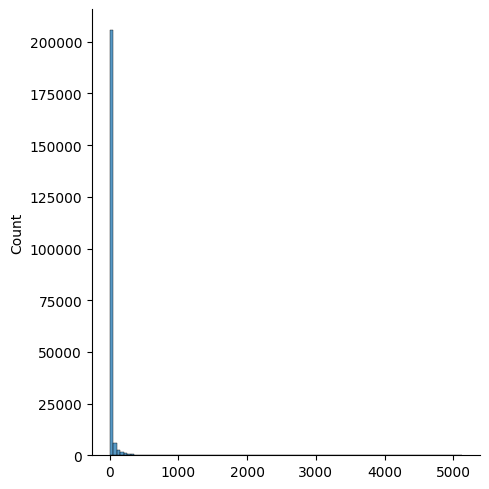

In [25]:
sns.displot(preds, bins=100)

In [26]:
X_test.shape[0], preds[preds < 0].shape,  preds[preds > 0].shape

(218828, (0,), (90101,))

In [27]:
X_test

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,period_day,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
3340387,2022-11-01,1,5,1,-1,1078,9118,13385,29814,2022,1,1,11,1.667261e+09,-1,31,99,23,139,30
3340388,2022-11-01,1,5,1,-1,1078,9118,28149,29814,2022,1,1,11,1.667261e+09,-1,31,99,23,11,27
3340389,2022-11-01,1,5,1,-1,1078,10863,28862,31858,2022,1,1,11,1.667261e+09,-1,31,148,23,118,11
3340390,2022-11-01,1,5,1,-1,1078,10863,9746,31858,2022,1,1,11,1.667261e+09,-1,31,148,23,19,23
3340391,2022-11-01,1,5,1,-1,1074,33741,9170,26007,2022,1,1,11,1.667261e+09,-1,31,160,43,97,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559210,2023-03-01,0,2,2,2129,1697,35809,30792,25817,2023,1,2,3,1.677629e+09,519,39,79,10,2,12
3559211,2023-03-01,0,2,2,2129,1697,35809,31112,25817,2023,1,2,3,1.677629e+09,519,39,79,10,4,12
3559212,2023-03-01,0,2,2,2129,1708,35667,38470,25817,2023,1,2,3,1.677629e+09,519,39,79,10,76,6
3559213,2023-03-01,0,2,2,2129,2120,35809,36430,25817,2023,1,2,3,1.677629e+09,519,14,79,10,8,16


# Evaluate

In [28]:
import numpy as np


def evaluate(fact: pd.DataFrame, forecast: pd.DataFrame, public: bool = True) -> float:
    # = Параметры для расчета метрики =
    accuracy_granularity = [
        "period",
        "rps",
        "holding_name",
        "sender_department_name",
        "recipient_department_name",
    ]
    fact_value, forecast_value = "real_wagon_count", "forecast_wagon_count"
    if public:
        metric_weight = np.array([0.0, 1.0, 0.0, 0.0, 0.0])
    else:
        metric_weight = np.array([0.1, 0.6, 0.1, 0.1, 0.1])

    # = Собственно расчет метрик =
    # 1. Добавляем сущности верхних уровней гранулярности по справочникам
    # fact = add_master_data_mappings(fact)
    # forecast = add_master_data_mappings(forecast)

    # 2. Расчет KPI
    compare_data = pd.merge(
        fact.groupby(accuracy_granularity, as_index=False)[fact_value].sum(),
        forecast.groupby(accuracy_granularity, as_index=False)[forecast_value].sum(),
        how="outer",
        on=accuracy_granularity,
    ).fillna(0)
    # Против самых хитрых - нецелочисленный прогноз вагоноотправок не принимаем
    compare_data[fact_value] = np.around(compare_data[fact_value]).astype(int)
    compare_data[forecast_value] = np.around(compare_data[forecast_value]).astype(int)

    # 3. Рассчитаем метрики для каждого месяца в выборке
    compare_data["ABS_ERR"] = abs(
        compare_data[forecast_value] - compare_data[fact_value]
    )
    compare_data["MAX"] = abs(compare_data[[forecast_value, fact_value]].max(axis=1))
    summary = compare_data.groupby("period")[
        [forecast_value, fact_value, "ABS_ERR", "MAX"]
    ].sum()
    summary["Forecast Accuracy"] = 1 - summary["ABS_ERR"] / summary["MAX"]

    # 4. Взвесим метрики отдельных месяцев для получения одной цифры score
    score = (
        summary["Forecast Accuracy"].sort_index(ascending=True) * metric_weight
    ).sum()

    return score


def calc_score_public(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=True)


def calc_score_private(fact: pd.DataFrame, forecast: pd.DataFrame) -> float:
    return evaluate(fact, forecast, public=False)

In [32]:
fact = X_test.copy()
fact["real_wagon_count"] = preds
fact = fact[fact["real_wagon_count"] > 0]

forecast = X_test.copy()
forecast["forecast_wagon_count"] = y_test

In [33]:
forecast

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,period_year,...,period_weekday,period_month,period_seconds,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name,forecast_wagon_count
3340387,2022-11-01,1,5,1,-1,1078,9118,13385,29814,2022,...,1,11,1.667261e+09,-1,31,99,23,139,30,1
3340388,2022-11-01,1,5,1,-1,1078,9118,28149,29814,2022,...,1,11,1.667261e+09,-1,31,99,23,11,27,3
3340389,2022-11-01,1,5,1,-1,1078,10863,28862,31858,2022,...,1,11,1.667261e+09,-1,31,148,23,118,11,3
3340390,2022-11-01,1,5,1,-1,1078,10863,9746,31858,2022,...,1,11,1.667261e+09,-1,31,148,23,19,23,2
3340391,2022-11-01,1,5,1,-1,1074,33741,9170,26007,2022,...,1,11,1.667261e+09,-1,31,160,43,97,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559210,2023-03-01,0,2,2,2129,1697,35809,30792,25817,2023,...,2,3,1.677629e+09,519,39,79,10,2,12,3
3559211,2023-03-01,0,2,2,2129,1697,35809,31112,25817,2023,...,2,3,1.677629e+09,519,39,79,10,4,12,1
3559212,2023-03-01,0,2,2,2129,1708,35667,38470,25817,2023,...,2,3,1.677629e+09,519,39,79,10,76,6,10
3559213,2023-03-01,0,2,2,2129,2120,35809,36430,25817,2023,...,2,3,1.677629e+09,519,14,79,10,8,16,1


In [34]:
# Скорим
score_public = calc_score_public(fact, forecast)
score_private = calc_score_private(fact, forecast)
print(f"Public score: {score_public}")
print(f"Private score: {score_private}")

Public score: 0.6159311265690937
Private score: 0.562187435265229


In [ ]:
С отрицательными значениями: 
Public score: 0.6031490080789712
Private score: 0.41790083598674166

Предикты меньше 0 заменить 0
Public score: 0.6159311265690937
Private score: 0.562187435265229

Все записи, где 0 дропнуть
Public score: 0.6159311265690937
Private score: 0.562187435265229

# Final Model

In [30]:
data = data.drop(columns=["is_test"])
X, y = data.drop(columns=["real_wagon_count"]), data["real_wagon_count"]

In [33]:
model = CatBoostRegressor(
    random_state=42,
    task_type="GPU",
    loss_function="RMSE",
    learning_rate=0.14917,
    n_estimators=650
)

In [34]:
model.fit(
    X,
    y,
    cat_features=["rps", "podrod", "filial", "client_sap_id", "freight_id", "sender_station_id", "recipient_station_id", "sender_organisation_id"] + cat_datetime_fe,
)

0:	learn: 126.7622382	total: 65.9ms	remaining: 42.7s
1:	learn: 124.8323623	total: 123ms	remaining: 39.8s
2:	learn: 123.3459789	total: 220ms	remaining: 47.4s
3:	learn: 122.1439484	total: 273ms	remaining: 44.1s
4:	learn: 120.9586590	total: 318ms	remaining: 41s
5:	learn: 119.4221256	total: 415ms	remaining: 44.5s
6:	learn: 118.0671206	total: 473ms	remaining: 43.4s
7:	learn: 117.0448264	total: 533ms	remaining: 42.7s
8:	learn: 116.1826454	total: 631ms	remaining: 44.9s
9:	learn: 115.0605560	total: 677ms	remaining: 43.4s
10:	learn: 113.9893702	total: 718ms	remaining: 41.7s
11:	learn: 113.2687347	total: 824ms	remaining: 43.8s
12:	learn: 112.7921250	total: 867ms	remaining: 42.5s
13:	learn: 111.9574686	total: 927ms	remaining: 42.1s
14:	learn: 111.5653147	total: 1.01s	remaining: 42.7s
15:	learn: 111.0117858	total: 1.07s	remaining: 42.3s
16:	learn: 110.7016918	total: 1.11s	remaining: 41.4s
17:	learn: 110.2678579	total: 1.16s	remaining: 40.7s
18:	learn: 109.9533685	total: 1.26s	remaining: 41.7s
19:	